# Notebook demonstrating importing and transforming survey data

In [1]:
%matplotlib inline

In [2]:
def read_datadict(datadir='./dat', filename='orb_datadict.txt'):
    import os
    filepath = os.path.join(datadir, filename)
    with open(filepath, encoding='utf-8') as fd: data = fd.readlines()
    data = [d for d in data if d.strip()]
    for i in range(len(data)):
        if data[i][0]!='\t': data[i] = [x.strip() for x in data[i].split(':')]
        else: data[i] = [data[i].strip()]
    dmap = {}
    text = {}
    curr = ''
    multi = ''
    for d in data:
        if len(d)==1:
            tmp = d[0].split('\t')
            if len(tmp)==2:
                if tmp[0][0]=='[':
                    curr = tmp[0][1:-1]
                    desc = tmp[1].strip()
                    text[curr] = desc
                    dmap[curr] = dmap[multi].copy()
                else:
                    dmap[curr][tmp[1]] = int(tmp[0])
        elif len(d)>1:
            if d[0][0]=='[':
                curr = d[0][1:-1]
                desc = d[1].strip()
                text[curr] = desc
                dmap[curr] = {}
            elif d[0]!='Values':
                curr = d[0]
                desc = d[1].strip()
                text[curr] = desc
                dmap[curr] = {}
                multi = curr
    errata = {'DREL':{'Other Christian:':'Other Christian:\xa0'},
              'DPOLUK':{'Other:':'Other:\xa0'}
                }
    extras = {'imageseen':{'ANTI US':1, 'PRO US':0, 'ANTI UK':1, 'PRO UK':0}, 
              'agerecode':{ '18-24':1, '25-34':2, '35-44':3, '45-54':4, '55-64':5, '65+':6}}
    for key in errata:
        if key in dmap:
            for label in errata[key]:
                if label in dmap[key]:
                    dmap[key][errata[key][label]] = dmap[key][label]
                    del dmap[key][label]
    for key in extras: dmap[key] = extras[key]
    return {'dict':dmap,'desc':text}

In [3]:
dd = read_datadict()

In [4]:
def import_data(filename='orb_200918.sav', datadir='./dat', dd={}):
    import os
    import pandas as pd
    filepath = os.path.join(datadir, filename)
    if filepath[-4:] == '.sav': df = pd.read_spss(filepath)
    else: df = pd.read_csv(filepath)
    recode = {}
    rename = {'country': 'Country'}
    for att in list(df):
        try: df[att].str.strip('\xa0')
        except: pass
    df.replace(recode, inplace=True)
    df.rename(columns=rename, inplace=True)
    if dd:
        for name in rename:
            for i in ['dict', 'desc']:
                if name in dd[i]:
                    try: dd[i][rename[name]] = dd[i][name].copy()
                    except:  dd[i][rename[name]] = dd[i][name]
                    del dd[i][name]
    return df

In [5]:
df = import_data(dd=dd)
print(df.shape)

(8002, 194)


In [6]:
df.head()

,record,uuid,date,status,Country,DGEOUS,USregion,DGEOUSb,DGEOUK,DAGE,...,QCOVAFFr4,RID,imageseen,UK_REGION,weight1,weight2,weight3,weight4,UK_EDUCATION_WEIGHT,US_EDUCATION_WEIGHT
0,2560.0,9kgt6f03ag320d45,1.381889e+10,Qualified,USA,Georgia,South,Fulton County,NaN,38.0,...,Tend to agree,5f56857a-0e94-fd72-7298-1cfa7c0fc2b8,ANTI US,0,1.142832,0.0,0.0,0.0,NaN,College Graduates
1,2577.0,06pp325q9byqs5ju,1.381889e+10,Qualified,USA,Kentucky,South,Lyon County,NaN,56.0,...,Strongly agree,5f5685f1-4287-da4f-ed4c-b045e6b334b2,ANTI US,0,0.642401,0.0,0.0,0.0,NaN,HS or less
2,2527.0,fmadd3d3mkrehh37,1.381889e+10,Qualified,USA,Alabama,South,Montgomery County,NaN,55.0,...,Strongly agree,5f568458-15f8-a41e-7e2e-617d80ba5353,ANTI US,0,0.733999,0.0,0.0,0.0,NaN,College Graduates
3,2551.0,b2z0kap8hn599d84,1.381889e+10,Qualified,USA,Georgia,South,Bartow County,NaN,21.0,...,Tend to agree,5f56852e-6baf-6e74-a275-7366d2fc910b,ANTI US,0,2.183532,0.0,0.0,0.0,NaN,Some college
4,2536.0,b4j7dkeht3z67v69,1.381889e+10,Qualified,USA,Virginia,South,Northampton County,NaN,52.0,...,Tend to disagree,5f5684aa-1ea7-a295-ddfa-8ee7c041d769,ANTI US,0,0.857459,0.0,0.0,0.0,NaN,College Graduates


Note that variable names match the corresponding question in the questionnaire (see `.doc/`). Next, we transform the data, which largely involves recoding the variables and relabeling them aptly.

In [7]:
def transform_data(df, dd, country='UK', group=None, save=''):
    
    demo = {'UK': {'agerecode':'Age', 'DGEN':'Gender', 'DEDUUK':'Education_UK', 'DEMP':'Employment', 'DREL':'Religion', 
                  'DPOLUK':'Political_UK', 'DETHUK':'Ethnicity_UK', 'DINCUK':'Income_UK', 'DGEOUK':'Region'},
            'USA': {'agerecode':'Age', 'DGEN':'Gender', 'DEDUUS':'Education_US', 'DEMP':'Employment', 'DREL':'Religion',
                    'DPOLUS':'Political_US', 'DETHUS':'Ethnicity_US', 'DINCUS':'Income_US', 'DGEOUS':'Region'}}
    
    var_encoding = {'Gender':{(1,):'Male', (2,):'Female', (3, 4):'Other'},
                    'Education_US':{(1, 2):'Level-0', (3,):'Level-1', (4,):'Level-2', (5,):'Level-3', (6,):'Level-4', (7, 8):'Other'}, 
                    'Education_UK':{(1,):'Level-0', (2, 3):'Level-1', (5,):'Level-2', (6,):'Level-3', (7,):'Level-4', (4, 8, 9):'Other'}, 
                    'Employment':{(1, 2):'Employed', (3,):'Unemployed', (4,):'Student', (6,):'Retired', (5, 7, 8):'Other'},
                    'Religion':{(1, 2, 3):'Christian', (4,):'Jewish', (6,):'Muslim', (9,):'Atheist', (5, 7, 8, 10):'Other'},
                    'Political_US':{(1,):'Republican', (2,):'Democrat', (3, 4, 5):'Other'},
                    'Political_US_ind':{(1,):'Republican', (2,):'Democrat', (3, 4):'Other'},
                    'Political_UK':{(1,):'Conservative', (2,):'Labour', (3,):'Liberal-Democrat', (4,):'SNP', (5,6,7):'Other'},
                    'Ethnicity_US':{(1,):'White', (2,):'Hispanic', (3,):'Black', (5,):'Asian', (4, 6, 7, 8):'Other'},
                    'Ethnicity_UK':{(1, 2, 3):'White', (4, 11):'Black', (5, 6, 7, 8, 9, 10):'Asian', (12, 13):'Other'},
                    'Income_US':{(1,):'Level-0', (2, 3):'Level-1', (4, 5): 'Level-2', (6, 7, 8, 9):'Level-3', (10,):'Level-4', (11,):'Other'},
                    'Income_UK':{(1,):'Level-0', (2,):'Level-1', (3,):'Level-2', (4, 5,):'Level-3', (6, 7, 8, 9, 10):'Level-4', (11,):'Other'}
                   }
    
    metrics_any = {'QINFr1': 'Nobody', 'QINFr2': 'Myself', 'QINFr3': 'Family inside HH', 'QINFr4': 'Family outside HH', 
                   'QINFr5': 'Close friend', 'QINFr6': 'Colleague'}    
    metrics_knl = {'QKNLr1': 'Washing hands', 'QKNLr2': 'Staying indoors for Self', 'QKNLr3': 'Staying indoors for Others', 
                   'QKNLr4': 'Spread before symptoms', 'QKNLr5': 'R-Number', 'QKNLr6': 'Treatments already exist', 'QKNLr7': 'Wearing masks'}
    metrics_cov = {'QCOVVCIr3': 'COVID-19 Vax Importance', 'QCOVVCIr1': 'COVID-19 Vax Safety', 'QCOVVCIr2': 'COVID-19 Vax Efficacy', 
                   'QCOVVCIr4': 'COVID-19 Vax Compatibility', 'QCOVVCIr5': 'Contract via COVID-19 Vax', 'QCOVVCIr6': 'COVID-19 Vax benefits outweigh risks'}
    metrics_vci = {'QVCIr1': 'Vax Importance', 'QVCIr2': 'Vax Safety', 'QVCIr3': 'Vax Efficacy', 'QVCIr4': 'Vax Compatibility'}
    metrics_aff = {'QCOVAFFr1': 'Mental health', 'QCOVAFFr2': 'Financial stability', 'QCOVAFFr3': 'Daily disruption', 'QCOVAFFr4': 'Social disruption'}
    trust = {'UK': {'QSRCUKr1': 'Television', 'QSRCUKr2': 'Radio', 'QSRCUKr3': 'Newspapers', 'QSRCUKr4': 'Govt. Briefings', 
                    'QSRCUKr5': 'National Health Authorities', 'QSRCUKr6': 'International Health Authorities', 'QSRCUKr7': 'Healthcare Workers', 
                    'QSRCUKr8': 'Scientists', 'QSRCUKr9': 'Govt. Websites', 'QSRCUKr10': 'Social Media', 'QSRCUKr11': 'Celebrities', 'QSRCUKr12': 'Search Engines', 
                    'QSRCUKr13': 'Family and friends', 'QSRCUKr14': 'Work Guidelines', 'QSRCUKr15': 'Other', 'QSRCUKr16': 'None of these'},
             'USA': {'QSRCUSr1': 'Television', 'QSRCUSr2': 'Radio', 'QSRCUSr3': 'Newspapers', 'QSRCUSr4': 'White House Briefings', 'QSRCUSr5':'State Govt. Briefings', 
                     'QSRCUSr6': 'National Health Authorities', 'QSRCUSr7': 'International Health Authorities', 'QSRCUSr8':'Healthcare Workers', 
                     'QSRCUSr9': 'Scientists', 'QSRCUSr10': 'Govt. Websites', 'QSRCUSr11': 'Social Media', 'QSRCUSr12': 'Celebrities', 'QSRCUSr13': 'Search Engines', 
                     'QSRCUSr14': 'Family and friends', 'QSRCUSr15': 'Work Guidelines', 'QSRCUSr16': 'Other', 'QSRCUSr17': 'None of these'}}
    reasons = {'QCOVSELFWHYr1': 'Unsure if safe', 'QCOVSELFWHYr2': 'Unsure if effective', 'QCOVSELFWHYr3': 'Not at risk', 'QCOVSELFWHYr4': 'Wait until others',
               'QCOVSELFWHYr5': "Won't be ill", 'QCOVSELFWHYr6': 'Other effective treatments', 'QCOVSELFWHYr7': 'Already acquired immunity',
               'QCOVSELFWHYr8': 'Approval may be rushed', 'QCOVSELFWHYr9': 'Other', 'QCOVSELFWHYr10': 'Do not know'}
    metrics_img = {'QPOSTVACX_Lr': 'Vaccine Intent', 'QPOSTBELIEFX_Lr': 'Agreement', 'QPOSTTRUSTX_Lr': 'Trust', 
                   'QPOSTCHECKX_Lr': 'Fact-check', 'QPOSTSHARE_Lr': 'Share'}
    social_atts = {'QSOCTYPr': 'used', 'QSOCINFr': 'to receive info', 'QCIRSHRr': 'to share info'}
    other_atts = {'QSHD':'Shielding',
                  'QSOCUSE':'Social media usage', 
                  'QCOVWHEN':'Expected vax availability',
                  'QPOSTSIM':'Seen such online content',
                  'QPOSTFRQ':'Frequency of such online content',
                  'Q31b':'Engaged with such online content',
                  'QCOVSELF':'Vaccine Intent for self (Pre)', 
                  'QPOSTCOVSELF':'Vaccine Intent for self (Post)',
                  'QCOVOTH':'Vaccine Intent for others (Pre)', 
                  'QPOSTCOVOTH':'Vaccine Intent for others (Post)', 
                  'imageseen':'Group'}
             
    def expand_socc(code):
        names = ['Facebook', 'Twitter', 'YouTube', 'WhatsApp', 'Instagram', 'Pinterest', 'LinkedIN', 'Other', 'None of these']
        out = {}
        for k in code:
             for i in range(len(names)): out['%s%i'%(k, i+1)] = '%s %s'%(names[i], code[k])
        return out
    
    def demo_map(code):
        fwd, bwd = {}, {}
        for key in code:
            fwd[key] = dict(zip(code[key].values(), range(1, len(code[key])+1)))
            bwd[key] = dict(zip(range(1, len(code[key])+1), code[key].values()))
        return fwd, bwd
    
    def expand_imgc(code, num=5):
        out = {}
        for i in range(num):
            for c in code:
                out['%s%i'%(c, i+1)] = 'Image %i:%s'%(i+1, code[c])
        return out
             
    def expand_code(code):
        new = {}
        for key in code:
            new[key] = {}
            for k, v in code[key].items():
                for i in k: new[key][i] = v
        return new
    
    metrics_img = expand_imgc(metrics_img)
    social_atts = expand_socc(social_atts)
    var_fwd, var_bwd = demo_map(var_encoding)
    var_encoding = expand_code(var_encoding)    
    
    atts = list(metrics_any.keys())+list(metrics_knl.keys())+list(metrics_cov.keys())+list(metrics_vci.keys())+list(metrics_aff.keys())
    atts += list(trust[country].keys())+list(reasons.keys())+list(metrics_img.keys())+list(social_atts.keys())
    atts += list(other_atts.keys())+list(demo[country].keys())
    
    def recode_treatment(x): return int('ANTI' in x)
            
    def recode_bools(x): return int('NO TO:' not in x)
        
    def recode_likert(x, inverse=False):
        if inverse: m = {'Strongly agree': -2, 'Tend to agree': -1, 'Tend to disagree': 1, 'Strongly disagree': 2, 'Do not know': 0}
        else: m = {'Strongly agree': 2, 'Tend to agree': 1, 'Tend to disagree': -1, 'Strongly disagree': -2, 'Do not know': 0}
        return m[x]
    
    def recode_likert_num(x, inverse=False):
        if inverse: m = [-2,-1,0,1,2,0]
        else: m = [2,1,0,-1,-2,0]
        return m[x-1]
    
    def recode_age(x):
        if x>118: x = 118
        return (x-18)/100
    
    if group is None:
        idx = df['Country']==country
        if country=='UK': idx = idx & ((df['imageseen']=='PRO UK')|(df['imageseen']=='ANTI UK')) #Country field is unreliable, has a bug
        elif country=='USA': idx = idx & ((df['imageseen']=='PRO US')|(df['imageseen']=='ANTI US'))
    else:
        if country=='UK': idx = df['imageseen']==group+' UK'
        elif country=='USA': idx = df['imageseen']==group+' US'    
    
    df_new = df.loc[idx,atts]
    dd_new = {}
    
    for key in metrics_any:
        df_new[key] = df_new[key].apply(recode_bools)
        df_new.rename(columns={key:'Know anyone:%s'%metrics_any[key]}, inplace=True)
        dd_new['Know anyone:%s'%metrics_any[key]] = {1:'Checked', 0:'Unchecked'}
    for key in metrics_knl:
        df_new[key] = df_new[key].apply(recode_likert)
        df_new.rename(columns={key:'COVID-19 Knowledge:%s'%metrics_knl[key]}, inplace=True)
        dd_new['COVID-19 Knowledge:%s'%metrics_knl[key]] = {2:'Strongly agree',1:'Tend to agree',0:'Do not know',-1:'Tend to disagree',-2:'Strongly disagree'}
    for key in metrics_cov:
        df_new[key] = df_new[key].apply(recode_likert)
        df_new.rename(columns={key:'COVID-19 VCI:%s'%metrics_cov[key]}, inplace=True)
        dd_new['COVID-19 VCI:%s'%metrics_cov[key]] = {2:'Strongly agree',1:'Tend to agree',0:'Do not know',-1:'Tend to disagree',-2:'Strongly disagree'}
    for key in metrics_vci:
        df_new[key] = df_new[key].apply(recode_likert)
        df_new.rename(columns={key:'General VCI:%s'%metrics_vci[key]}, inplace=True)
        dd_new['General VCI:%s'%metrics_vci[key]] = {2:'Strongly agree',1:'Tend to agree',0:'Do not know',-1:'Tend to disagree',-2:'Strongly disagree'}
    for key in metrics_aff:
        df_new[key] = df_new[key].apply(recode_likert)
        df_new.rename(columns={key:'COVID-19 Impact:%s'%metrics_aff[key]}, inplace=True)
        dd_new['COVID-19 Impact:%s'%metrics_aff[key]] = {2:'Strongly agree',1:'Tend to agree',0:'Do not know',-1:'Tend to disagree',-2:'Strongly disagree'}
             
    for key in trust[country]:
        df_new[key] = df_new[key].apply(recode_bools)
        df_new.rename(columns={key:'Trust:%s'%trust[country][key]}, inplace=True)
        dd_new['Trust:%s'%trust[country][key]] = {1:'Checked', 0:'Unchecked'}
    for key in reasons:
        df_new[key] = df_new[key].apply(recode_bools)
        df_new.rename(columns={key:'Reason:%s'%reasons[key]}, inplace=True)
        dd_new['Reason:%s'%reasons[key]] = {1:'Checked', 0:'Unchecked'}
    for key in social_atts:
        df_new[key] = df_new[key].apply(recode_bools)
        df_new.rename(columns={key:'Social:%s'%social_atts[key]}, inplace=True)
        dd_new['Social:%s'%social_atts[key]] = {1:'Checked', 0:'Unchecked'}
    
    for key in metrics_img:
        df_new.replace({key: dd['dict'][key]}, inplace=True)
        df_new[key] = df_new[key].apply(recode_likert_num)
        df_new.rename(columns={key:metrics_img[key]}, inplace=True)
        dd_new[metrics_img[key]] = {2:'Strongly agree',1:'Tend to agree',0:'Do not know',-1:'Tend to disagree',-2:'Strongly disagree'}

        
    df_new.replace({att: dd['dict'][att] for att in other_atts if att!='imageseen'}, inplace=True)
    for att in other_atts:
        df_new.rename(columns={att:other_atts[att]}, inplace=True)
        if att!='imageseen': dd_new[other_atts[att]] = dict(zip(dd['dict'][att].values(), dd['dict'][att].keys()))
    
    df_new.replace({key: dd['dict'][key] for key in demo[country] if key not in ['agerecode', 'DGEOUK', 'DGEOUS']}, inplace=True)
    df_new.rename(columns=demo[country], inplace=True)
    df_new.replace(var_encoding, inplace=True)
    df_new.replace(var_fwd, inplace=True)
    for att in demo[country]:
        if demo[country][att] in var_fwd: dd_new[demo[country][att].split('_')[0]] = var_bwd[demo[country][att]]
        else:
            df_new.replace({demo[country][att]: dd['dict'][att]}, inplace=True)
            dd_new[demo[country][att]] = {b: a for (a, b) in dd['dict'][att].items()}
    df_new['Treatment'] = df_new['Group'].apply(recode_treatment)
    df_new.rename(columns={i:i.split('_')[0] for i in list(df_new)}, inplace=True)
    if save:
        df_new.to_csv('%s.csv'%save)
        import json
        with open('%s.json'%save, 'w') as fp: json.dump(dd_new, fp)
    return df_new, dd_new

In [8]:
df_uk, dd_uk = transform_data(df, dd, 'UK')#, save='dat/orb_uk')
df_us, dd_us = transform_data(df, dd, 'USA')#, save='dat/orb_us')

In [9]:
list(df_uk)

['Know anyone:Nobody',
 'Know anyone:Myself',
 'Know anyone:Family inside HH',
 'Know anyone:Family outside HH',
 'Know anyone:Close friend',
 'Know anyone:Colleague',
 'COVID-19 Knowledge:Washing hands',
 'COVID-19 Knowledge:Staying indoors for Self',
 'COVID-19 Knowledge:Staying indoors for Others',
 'COVID-19 Knowledge:Spread before symptoms',
 'COVID-19 Knowledge:R-Number',
 'COVID-19 Knowledge:Treatments already exist',
 'COVID-19 Knowledge:Wearing masks',
 'COVID-19 VCI:COVID-19 Vax Importance',
 'COVID-19 VCI:COVID-19 Vax Safety',
 'COVID-19 VCI:COVID-19 Vax Efficacy',
 'COVID-19 VCI:COVID-19 Vax Compatibility',
 'COVID-19 VCI:Contract via COVID-19 Vax',
 'COVID-19 VCI:COVID-19 Vax benefits outweigh risks',
 'General VCI:Vax Importance',
 'General VCI:Vax Safety',
 'General VCI:Vax Efficacy',
 'General VCI:Vax Compatibility',
 'COVID-19 Impact:Mental health',
 'COVID-19 Impact:Financial stability',
 'COVID-19 Impact:Daily disruption',
 'COVID-19 Impact:Social disruption',
 'Trus

In [10]:
def get_counts(df, dd, by='Treatment'):
    import pandas as pd
    atts = ['Age', 'Gender', 'Education', 'Employment', 'Religion', 'Political', 'Ethnicity', 'Income', 'Social media usage']
    out = []
    name = {0: 'Control', 1:'Treatment'}
    for idx, d in df.groupby(by):
        out.append({})
        for att in atts:
            tmp = d[att].value_counts().loc[list(dd[att].keys())]
            tmp.index = dd[att].values()
            tmp.name = '%s (N)'%name[idx]
            tmp_perc = (100*tmp/tmp.sum()).round(1)
            tmp_perc.name = '%s (%%)'%name[idx]
            out[-1][att] = pd.concat([tmp, tmp_perc], axis=1)
        out[-1] = pd.concat(out[-1], axis=0)
    out = pd.concat(out, axis=1)
    return out

In [11]:
get_counts(df_uk, dd_uk)

Control (N)  Control (%)  \
Age                18-24                                 140         14.0   
                   25-34                                 227         22.7   
                   35-44                                 190         19.0   
                   45-54                                 162         16.2   
                   55-64                                 127         12.7   
                   65+                                   154         15.4   
Gender             Male                                  421         42.1   
                   Female                                573         57.3   
                   Other                                   6          0.6   
Education          Level-0                                40          4.0   
                   Level-1                               276         27.6   
                   Level-2                               190         19.0   
                   Level-3                               258         25.8   
                   Level-4                               163         16.3   
                   Other                                  73          7.3   
Employment         Employed                              619         61.9   
                   Unemployed                             56          5.6   
                   Student                                64          6.4   
                   Retired                               151         15.1   
                   Other                                 110         11.0   
Religion           Christian                             442         44.2   
                   Jewish                                 10          1.0   
                   Muslim                                 34          3.4   
                   Atheist                               342         34.2   
                   Other                                 172         17.2   
Political          Conservative                          307         30.7   
                   Labour                                350         35.0   
                   Liberal-Democrat                       87          8.7   
                   SNP                                    44          4.4   
                   Other                                 212         21.2   
Ethnicity          White                                 872         87.2   
                   Black                                  27          2.7   
                   Asian                                  82          8.2   
                   Other                                  19          1.9   
Income             Level-0                               154         15.4   
                   Level-1                               197         19.7   
                   Level-2                               167         16.7   
                   Level-3                               230         23.0   
                   Level-4                               184         18.4   
                   Other                                  68          6.8   
Social media usage None                                  136         13.6   
                   Less than 10 minutes per day          122         12.2   
                   10–30 minutes per day                 215         21.5   
                   31–60 minutes per day                 160         16.0   
                   1–2 hours per day                     154         15.4   
                   2–3 hours per day                      94          9.4   
                   More than 3 hours per day             119         11.9   

                                                 Treatment (N)  Treatment (%)  
Age                18-24                                   364           12.1  
                   25-34                                   575           19.2  
                   35-44                                   586           19.5  
                   45-54        

In [12]:
get_counts(df_us, dd_us)

Control (N)  Control (%)  \
Age                18-24                                 232         23.2   
                   25-34                                 249         24.9   
                   35-44                                 226         22.6   
                   45-54                                  97          9.7   
                   55-64                                  75          7.5   
                   65+                                   121         12.1   
Gender             Male                                  492         49.2   
                   Female                                499         49.9   
                   Other                                   9          0.9   
Education          Level-0                                52          5.2   
                   Level-1                               301         30.1   
                   Level-2                               133         13.3   
                   Level-3                               234         23.4   
                   Level-4                               204         20.4   
                   Other                                  76          7.6   
Employment         Employed                              612         61.2   
                   Unemployed                            117         11.7   
                   Student                                82          8.2   
                   Retired                               110         11.0   
                   Other                                  79          7.9   
Religion           Christian                             583         58.3   
                   Jewish                                 27          2.7   
                   Muslim                                 57          5.7   
                   Atheist                                77          7.7   
                   Other                                 256         25.6   
Political          Republican                            298         29.8   
                   Democrat                              366         36.6   
                   Other                                 336         33.6   
Ethnicity          White                                 603         60.3   
                   Hispanic                              101         10.1   
                   Black                                 143         14.3   
                   Asian                                  60          6.0   
                   Other                                  93          9.3   
Income             Level-0                               178         17.8   
                   Level-1                               191         19.1   
                   Level-2                               126         12.6   
                   Level-3                               208         20.8   
                   Level-4                               226         22.6   
                   Other                                  71          7.1   
Social media usage None                                  114         11.4   
                   Less than 10 minutes per day           77          7.7   
                   10–30 minutes per day                 155         15.5   
                   31–60 minutes per day                 161         16.1   
                   1–2 hours per day                     157         15.7   
                   2–3 hours per day                     136         13.6   
                   More than 3 hours per day             200         20.0   

                                                 Treatment (N)  Treatment (%)  
Age                18-24                                   255            8.5  
                   25-34                                   480           16.0  
                   35-44                                   469           15.6  
                   45-54                                   570           19.0  
                   55-64     

In [13]:
def count_attribute(df, att, by_att=None, where=None, att_lab='', by_att_lab='', title='', dd={}, norm=False, nullify=[], null=False, plot='small'):
    from numpy import nan, newaxis
    df = df.replace(nullify, [nan]*len(nullify))
    if null: df.fillna('null', inplace=True)        
    if where is not None:
        if not isinstance(where, list): where = [where]
        for w in where:
            if w[1] is None: df = df[df[w[0]].isnull()]
            else: df = df[df[w[0]]==w[1]]
    if by_att is None: counts = df[att].value_counts()
    else:
        from pandas import concat
        groups = df[[att, by_att]].groupby(by_att)
        names = list()
        counts = list()
        for name, group in groups:
            names.append(name)
            counts.append(group[att].value_counts())
        counts = concat(counts, axis=1, keys=names, sort=True)
        if dd: counts = counts[dd['dict'][by_att].keys()]
    counts.fillna(0, inplace=True)
    #if norm: counts = counts/(counts.values.sum(1)[:,newaxis])
    if norm: counts = counts/counts.values.sum(0)
    if dd: counts = counts.loc[dd['dict'][att].keys()]
    if plot:
        import matplotlib.pyplot as plt
        if plot=='small': plt.figure(dpi=90)
        else: plt.figure(dpi=180)
        from seaborn import countplot
        order, hue_order = None, None
        if dd:
            order = dd['dict'][att].keys()
            if by_att is not None: hue_order = dd['dict'][by_att].keys()
        if by_att is None: countplot(y=att, data=df, order=order)
        else: countplot(y=att, hue=by_att, data=df, order=order, hue_order=hue_order)
        plt.gca().set_xlabel('Count')
        if att_lab: plt.gca().set_ylabel(att_lab)
        if by_att_lab: plt.gca().get_legend().set_title(by_att_lab)
        if not title and where is not None: title = ', '.join([str(w[0])+' = '+str(w[1]) for w in where])
        plt.title(title)
        plt.show()        
    return counts

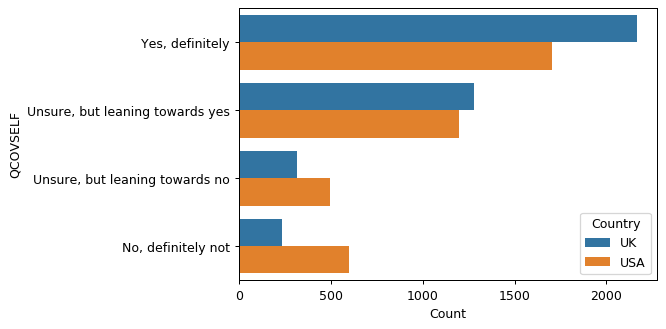

,UK,USA
"Yes, definitely",2167,1705
"Unsure, but leaning towards yes",1277,1200
"Unsure, but leaning towards no",318,497
"No, definitely not",238,600


In [14]:
count_attribute(df, 'QCOVSELF', 'Country', dd=dd)

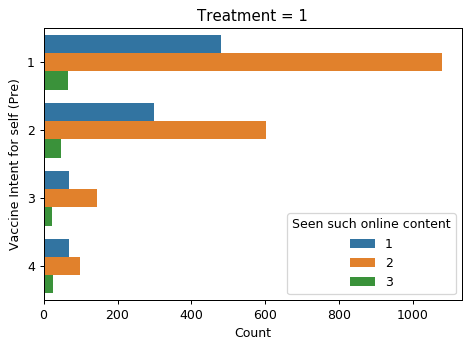

,1,2,3
1,480,1079,66
2,300,601,48
3,68,144,22
4,69,98,25


In [15]:
count_attribute(df_uk, 'Vaccine Intent for self (Pre)', 'Seen such online content', dd={'dict':dd_uk}, where=('Treatment', 1))

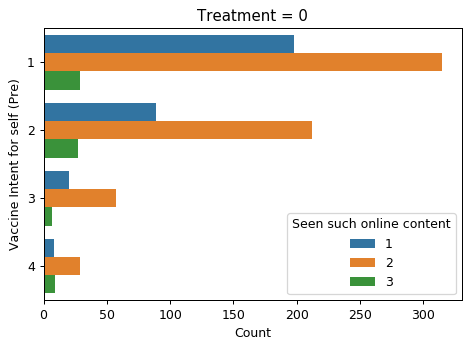

,1,2,3
1,198,315,29
2,89,212,27
3,20,57,7
4,8,29,9


In [16]:
count_attribute(df_uk, 'Vaccine Intent for self (Pre)', 'Seen such online content', dd={'dict':dd_uk}, where=('Treatment', 0))